## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.000001
BATCH_SIZE = 32
NUM_EPOCHS = 20

RESOLUTION = 200
NUM_FEATURES = RESOLUTION*RESOLUTION
NUM_CLASSES = 66

DEVICE = "cuda:0"
GRAYSCALE = False

In [4]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

path = 'CV_data/Extracted_dataset_input_combined'
dataset = datasets.ImageFolder(root=path, transform=transform)


# Get class to index mapping
class_to_idx = dataset.class_to_idx

# Define index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training set and test set
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break


Image batch dimensions: torch.Size([32, 3, 200, 200])
Image label dimensions: torch.Size([32])
Labels: tensor([39, 20, 39, 33,  5, 59, 10,  5, 25, 40, 48, 25, 51,  2, 20, 25,  5, 16,
        39, 64, 22, 22, 24,  5, 45, 47, 20, 60, 64, 16, 40,  0])


In [5]:
from collections import Counter


train_classes = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1 / torch.tensor(list(dict(sorted(dict(Counter(train_classes)).items())).values()))
class_weights

tensor([0.0003, 0.0028, 0.0013, 0.0008, 0.0024, 0.0005, 0.0016, 0.0164, 0.0017,
        0.0164, 0.0016, 0.0004, 0.0030, 0.0081, 0.0013, 0.0071, 0.0012, 0.0156,
        0.0024, 0.0034, 0.0031, 0.0145, 0.0034, 0.0008, 0.0012, 0.0006, 0.0025,
        0.0027, 0.0025, 0.0024, 0.0026, 0.0070, 0.0017, 0.0141, 0.0025, 0.0026,
        0.0013, 0.0065, 0.0030, 0.0013, 0.0010, 0.0023, 0.0027, 0.0008, 0.0002,
        0.0141, 0.0066, 0.0013, 0.0012, 0.0063, 0.0021, 0.0011, 0.0026, 0.0185,
        0.0025, 0.0026, 0.0133, 0.0161, 0.0027, 0.0066, 0.0022, 0.0006, 0.0020,
        0.0154, 0.0015, 0.0114])

In [6]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# Model

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [8]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [9]:
def compute_accuracy(model, data_loader, device, mode="train"):
    correct_pred, num_examples = 0, 0
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
        if not batch_idx % 50:
            accuracy = correct_pred.float() / num_examples * 100
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-accuracy.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {accuracy}\n")
            correct_pred, num_examples = 0, 0



In [10]:
def compute_loss(model, data_loader, class_weights, device, mode="val"):
    losses = []
    dataset_len = len(data_loader)
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
            
        logits, _ = model(features)
        loss = F.cross_entropy(logits, targets, weight=class_weights)
        losses.append(loss)
        
        if not batch_idx % 50:
            mean_loss = sum(losses) / len(losses)
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-loss.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
            losses.clear()

In [11]:
model_name = "05-model"

## Training

In [11]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            class_weights = class_weights.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, weight=class_weights)
            losses.append(loss)

            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss))

                mean_loss = sum(losses) / len(losses)
                with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-train-loss.csv', 'a') as fp:
                    fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
                losses.clear()


        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            compute_accuracy(model, train_loader, device=DEVICE, mode="train")
            compute_loss(model, val_loader, class_weights, device=DEVICE, mode="val")
            compute_accuracy(model, val_loader, device=DEVICE, mode="val")

        file_path = f'CV_data/models/{model_name}-{LEARNING_RATE}-epoch{epoch+1}.pth'
        torch.save(model.state_dict(), file_path)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/1284 | Cost: 4.3065
Epoch: 001/020 | Batch 0050/1284 | Cost: 4.4109
Epoch: 001/020 | Batch 0100/1284 | Cost: 4.3018
Epoch: 001/020 | Batch 0150/1284 | Cost: 4.1962


/data/leuven/354/vsc35486/miniconda3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 001/020 | Batch 0200/1284 | Cost: 4.0845
Epoch: 001/020 | Batch 0250/1284 | Cost: 4.2273
Epoch: 001/020 | Batch 0300/1284 | Cost: 4.1970
Epoch: 001/020 | Batch 0350/1284 | Cost: 4.0944
Epoch: 001/020 | Batch 0400/1284 | Cost: 4.2750
Epoch: 001/020 | Batch 0450/1284 | Cost: 4.1071
Epoch: 001/020 | Batch 0500/1284 | Cost: 4.1310
Epoch: 001/020 | Batch 0550/1284 | Cost: 3.9094
Epoch: 001/020 | Batch 0600/1284 | Cost: 4.2246
Epoch: 001/020 | Batch 0650/1284 | Cost: 3.8608
Epoch: 001/020 | Batch 0700/1284 | Cost: 3.8237
Epoch: 001/020 | Batch 0750/1284 | Cost: 4.0817
Epoch: 001/020 | Batch 0800/1284 | Cost: 4.0860
Epoch: 001/020 | Batch 0850/1284 | Cost: 3.6471
Epoch: 001/020 | Batch 0900/1284 | Cost: 4.0780
Epoch: 001/020 | Batch 0950/1284 | Cost: 3.8637
Epoch: 001/020 | Batch 1000/1284 | Cost: 3.9641
Epoch: 001/020 | Batch 1050/1284 | Cost: 3.8373
Epoch: 001/020 | Batch 1100/1284 | Cost: 3.8262
Epoch: 001/020 | Batch 1150/1284 | Cost: 3.6095
Epoch: 001/020 | Batch 1200/1284 | Cost:

1284it [01:53, 11.30it/s]
428it [00:34, 12.41it/s]
428it [00:34, 12.51it/s]


Time elapsed: 5.54 min
Epoch: 002/020 | Batch 0000/1284 | Cost: 3.7672
Epoch: 002/020 | Batch 0050/1284 | Cost: 3.4519
Epoch: 002/020 | Batch 0100/1284 | Cost: 3.3414
Epoch: 002/020 | Batch 0150/1284 | Cost: 3.4510
Epoch: 002/020 | Batch 0200/1284 | Cost: 3.7667
Epoch: 002/020 | Batch 0250/1284 | Cost: 3.4942
Epoch: 002/020 | Batch 0300/1284 | Cost: 3.5777
Epoch: 002/020 | Batch 0350/1284 | Cost: 3.3492
Epoch: 002/020 | Batch 0400/1284 | Cost: 3.4175
Epoch: 002/020 | Batch 0450/1284 | Cost: 3.3979
Epoch: 002/020 | Batch 0500/1284 | Cost: 3.1414
Epoch: 002/020 | Batch 0550/1284 | Cost: 3.4919
Epoch: 002/020 | Batch 0600/1284 | Cost: 3.0835
Epoch: 002/020 | Batch 0650/1284 | Cost: 3.2736
Epoch: 002/020 | Batch 0700/1284 | Cost: 3.7277
Epoch: 002/020 | Batch 0750/1284 | Cost: 3.3284
Epoch: 002/020 | Batch 0800/1284 | Cost: 3.1898
Epoch: 002/020 | Batch 0850/1284 | Cost: 3.1504
Epoch: 002/020 | Batch 0900/1284 | Cost: 3.3976
Epoch: 002/020 | Batch 0950/1284 | Cost: 3.1364
Epoch: 002/020 | 

1284it [01:50, 11.61it/s]
428it [00:36, 11.83it/s]
428it [00:33, 12.70it/s]


Time elapsed: 10.81 min
Epoch: 003/020 | Batch 0000/1284 | Cost: 3.3906
Epoch: 003/020 | Batch 0050/1284 | Cost: 2.5616
Epoch: 003/020 | Batch 0100/1284 | Cost: 3.0817
Epoch: 003/020 | Batch 0150/1284 | Cost: 3.0567
Epoch: 003/020 | Batch 0200/1284 | Cost: 3.0470
Epoch: 003/020 | Batch 0250/1284 | Cost: 2.3857
Epoch: 003/020 | Batch 0300/1284 | Cost: 2.4707
Epoch: 003/020 | Batch 0350/1284 | Cost: 2.7831
Epoch: 003/020 | Batch 0400/1284 | Cost: 3.2802
Epoch: 003/020 | Batch 0450/1284 | Cost: 2.4030
Epoch: 003/020 | Batch 0500/1284 | Cost: 2.7315
Epoch: 003/020 | Batch 0550/1284 | Cost: 2.7195
Epoch: 003/020 | Batch 0600/1284 | Cost: 2.9585
Epoch: 003/020 | Batch 0650/1284 | Cost: 2.5196
Epoch: 003/020 | Batch 0700/1284 | Cost: 3.1138
Epoch: 003/020 | Batch 0750/1284 | Cost: 2.5907
Epoch: 003/020 | Batch 0800/1284 | Cost: 2.8061
Epoch: 003/020 | Batch 0850/1284 | Cost: 2.9729
Epoch: 003/020 | Batch 0900/1284 | Cost: 2.2833
Epoch: 003/020 | Batch 0950/1284 | Cost: 2.8394
Epoch: 003/020 |

1284it [01:50, 11.63it/s]
428it [00:33, 12.64it/s]
428it [00:33, 12.59it/s]


Time elapsed: 16.04 min
Epoch: 004/020 | Batch 0000/1284 | Cost: 2.7671
Epoch: 004/020 | Batch 0050/1284 | Cost: 2.4477
Epoch: 004/020 | Batch 0100/1284 | Cost: 2.8134
Epoch: 004/020 | Batch 0150/1284 | Cost: 3.0876
Epoch: 004/020 | Batch 0200/1284 | Cost: 2.5632
Epoch: 004/020 | Batch 0250/1284 | Cost: 3.0242
Epoch: 004/020 | Batch 0300/1284 | Cost: 2.2908
Epoch: 004/020 | Batch 0350/1284 | Cost: 2.5244
Epoch: 004/020 | Batch 0400/1284 | Cost: 2.0133
Epoch: 004/020 | Batch 0450/1284 | Cost: 2.3188
Epoch: 004/020 | Batch 0500/1284 | Cost: 2.0570
Epoch: 004/020 | Batch 0550/1284 | Cost: 2.0245
Epoch: 004/020 | Batch 0600/1284 | Cost: 2.4700
Epoch: 004/020 | Batch 0650/1284 | Cost: 2.1576
Epoch: 004/020 | Batch 0700/1284 | Cost: 2.2319
Epoch: 004/020 | Batch 0750/1284 | Cost: 2.8760
Epoch: 004/020 | Batch 0800/1284 | Cost: 2.2808
Epoch: 004/020 | Batch 0850/1284 | Cost: 2.5570
Epoch: 004/020 | Batch 0900/1284 | Cost: 1.9863
Epoch: 004/020 | Batch 0950/1284 | Cost: 2.5397
Epoch: 004/020 |

1284it [01:50, 11.60it/s]
428it [00:33, 12.74it/s]
428it [00:33, 12.68it/s]


Time elapsed: 21.26 min
Epoch: 005/020 | Batch 0000/1284 | Cost: 3.0250
Epoch: 005/020 | Batch 0050/1284 | Cost: 1.9704
Epoch: 005/020 | Batch 0100/1284 | Cost: 2.4160
Epoch: 005/020 | Batch 0150/1284 | Cost: 2.3338
Epoch: 005/020 | Batch 0200/1284 | Cost: 2.2758
Epoch: 005/020 | Batch 0250/1284 | Cost: 2.1785
Epoch: 005/020 | Batch 0300/1284 | Cost: 2.0508
Epoch: 005/020 | Batch 0350/1284 | Cost: 2.4025
Epoch: 005/020 | Batch 0400/1284 | Cost: 2.1153
Epoch: 005/020 | Batch 0450/1284 | Cost: 1.8934
Epoch: 005/020 | Batch 0500/1284 | Cost: 2.2471
Epoch: 005/020 | Batch 0550/1284 | Cost: 2.2285
Epoch: 005/020 | Batch 0600/1284 | Cost: 2.2389
Epoch: 005/020 | Batch 0650/1284 | Cost: 2.5556
Epoch: 005/020 | Batch 0700/1284 | Cost: 2.8217
Epoch: 005/020 | Batch 0750/1284 | Cost: 2.1386
Epoch: 005/020 | Batch 0800/1284 | Cost: 2.2313
Epoch: 005/020 | Batch 0850/1284 | Cost: 1.7845
Epoch: 005/020 | Batch 0900/1284 | Cost: 2.3170
Epoch: 005/020 | Batch 0950/1284 | Cost: 2.1198
Epoch: 005/020 |

1284it [01:51, 11.52it/s]
428it [00:33, 12.61it/s]
428it [00:33, 12.62it/s]


Time elapsed: 26.51 min
Epoch: 006/020 | Batch 0000/1284 | Cost: 2.2857
Epoch: 006/020 | Batch 0050/1284 | Cost: 1.8951
Epoch: 006/020 | Batch 0100/1284 | Cost: 1.6566
Epoch: 006/020 | Batch 0150/1284 | Cost: 2.0509
Epoch: 006/020 | Batch 0200/1284 | Cost: 1.6262
Epoch: 006/020 | Batch 0250/1284 | Cost: 2.4949
Epoch: 006/020 | Batch 0300/1284 | Cost: 1.6273
Epoch: 006/020 | Batch 0350/1284 | Cost: 2.0262
Epoch: 006/020 | Batch 0400/1284 | Cost: 2.1582
Epoch: 006/020 | Batch 0450/1284 | Cost: 1.2751
Epoch: 006/020 | Batch 0500/1284 | Cost: 1.7338
Epoch: 006/020 | Batch 0550/1284 | Cost: 2.2218
Epoch: 006/020 | Batch 0600/1284 | Cost: 2.1668
Epoch: 006/020 | Batch 0650/1284 | Cost: 1.6095
Epoch: 006/020 | Batch 0700/1284 | Cost: 1.7825
Epoch: 006/020 | Batch 0750/1284 | Cost: 1.8456
Epoch: 006/020 | Batch 0800/1284 | Cost: 1.9636
Epoch: 006/020 | Batch 0850/1284 | Cost: 2.0342
Epoch: 006/020 | Batch 0900/1284 | Cost: 2.0567
Epoch: 006/020 | Batch 0950/1284 | Cost: 1.5988
Epoch: 006/020 |

1284it [01:52, 11.39it/s]
428it [00:34, 12.42it/s]
428it [00:33, 12.71it/s]


Time elapsed: 31.79 min
Epoch: 007/020 | Batch 0000/1284 | Cost: 1.8101
Epoch: 007/020 | Batch 0050/1284 | Cost: 1.3552
Epoch: 007/020 | Batch 0100/1284 | Cost: 1.8282
Epoch: 007/020 | Batch 0150/1284 | Cost: 1.7114
Epoch: 007/020 | Batch 0200/1284 | Cost: 1.7906
Epoch: 007/020 | Batch 0250/1284 | Cost: 1.7916
Epoch: 007/020 | Batch 0300/1284 | Cost: 1.6732
Epoch: 007/020 | Batch 0350/1284 | Cost: 1.8955
Epoch: 007/020 | Batch 0400/1284 | Cost: 1.9320
Epoch: 007/020 | Batch 0450/1284 | Cost: 1.6139
Epoch: 007/020 | Batch 0500/1284 | Cost: 2.0268
Epoch: 007/020 | Batch 0550/1284 | Cost: 1.6825
Epoch: 007/020 | Batch 0600/1284 | Cost: 1.6054
Epoch: 007/020 | Batch 0650/1284 | Cost: 1.5499
Epoch: 007/020 | Batch 0700/1284 | Cost: 1.8555
Epoch: 007/020 | Batch 0750/1284 | Cost: 2.3357
Epoch: 007/020 | Batch 0800/1284 | Cost: 1.3806
Epoch: 007/020 | Batch 0850/1284 | Cost: 1.6312
Epoch: 007/020 | Batch 0900/1284 | Cost: 1.3979
Epoch: 007/020 | Batch 0950/1284 | Cost: 1.7694
Epoch: 007/020 |

1284it [01:50, 11.62it/s]
428it [00:33, 12.64it/s]
428it [00:33, 12.69it/s]


Time elapsed: 37.02 min
Epoch: 008/020 | Batch 0000/1284 | Cost: 2.0071
Epoch: 008/020 | Batch 0050/1284 | Cost: 1.2088
Epoch: 008/020 | Batch 0100/1284 | Cost: 1.2336
Epoch: 008/020 | Batch 0150/1284 | Cost: 1.4804
Epoch: 008/020 | Batch 0200/1284 | Cost: 1.4963
Epoch: 008/020 | Batch 0250/1284 | Cost: 1.2601
Epoch: 008/020 | Batch 0300/1284 | Cost: 1.5707
Epoch: 008/020 | Batch 0350/1284 | Cost: 1.1760
Epoch: 008/020 | Batch 0400/1284 | Cost: 1.4201
Epoch: 008/020 | Batch 0450/1284 | Cost: 1.9485
Epoch: 008/020 | Batch 0500/1284 | Cost: 1.3996
Epoch: 008/020 | Batch 0550/1284 | Cost: 2.0046
Epoch: 008/020 | Batch 0600/1284 | Cost: 1.7860
Epoch: 008/020 | Batch 0650/1284 | Cost: 1.7079
Epoch: 008/020 | Batch 0700/1284 | Cost: 1.5090
Epoch: 008/020 | Batch 0750/1284 | Cost: 1.3099
Epoch: 008/020 | Batch 0800/1284 | Cost: 1.3787
Epoch: 008/020 | Batch 0850/1284 | Cost: 1.1837
Epoch: 008/020 | Batch 0900/1284 | Cost: 1.3320
Epoch: 008/020 | Batch 0950/1284 | Cost: 1.7069
Epoch: 008/020 |

1284it [01:50, 11.66it/s]
428it [00:33, 12.73it/s]
428it [00:33, 12.74it/s]


Time elapsed: 42.22 min
Epoch: 009/020 | Batch 0000/1284 | Cost: 1.0696
Epoch: 009/020 | Batch 0050/1284 | Cost: 1.5040
Epoch: 009/020 | Batch 0100/1284 | Cost: 2.0627
Epoch: 009/020 | Batch 0150/1284 | Cost: 1.4943
Epoch: 009/020 | Batch 0200/1284 | Cost: 1.6858
Epoch: 009/020 | Batch 0250/1284 | Cost: 1.1769
Epoch: 009/020 | Batch 0300/1284 | Cost: 1.1094
Epoch: 009/020 | Batch 0350/1284 | Cost: 1.3174
Epoch: 009/020 | Batch 0400/1284 | Cost: 1.7218
Epoch: 009/020 | Batch 0450/1284 | Cost: 1.3045
Epoch: 009/020 | Batch 0500/1284 | Cost: 1.3363
Epoch: 009/020 | Batch 0550/1284 | Cost: 1.4747
Epoch: 009/020 | Batch 0600/1284 | Cost: 1.2140
Epoch: 009/020 | Batch 0650/1284 | Cost: 1.5481
Epoch: 009/020 | Batch 0700/1284 | Cost: 1.7801
Epoch: 009/020 | Batch 0750/1284 | Cost: 1.5479
Epoch: 009/020 | Batch 0800/1284 | Cost: 1.1985
Epoch: 009/020 | Batch 0850/1284 | Cost: 1.3868
Epoch: 009/020 | Batch 0900/1284 | Cost: 1.1562
Epoch: 009/020 | Batch 0950/1284 | Cost: 1.0191
Epoch: 009/020 |

1284it [01:51, 11.47it/s]
428it [00:34, 12.52it/s]
428it [00:33, 12.69it/s]


Time elapsed: 47.47 min
Epoch: 010/020 | Batch 0000/1284 | Cost: 0.9846
Epoch: 010/020 | Batch 0050/1284 | Cost: 1.5089
Epoch: 010/020 | Batch 0100/1284 | Cost: 1.5437
Epoch: 010/020 | Batch 0150/1284 | Cost: 1.4136
Epoch: 010/020 | Batch 0200/1284 | Cost: 0.9810
Epoch: 010/020 | Batch 0250/1284 | Cost: 1.5450
Epoch: 010/020 | Batch 0300/1284 | Cost: 1.2573
Epoch: 010/020 | Batch 0350/1284 | Cost: 1.2065
Epoch: 010/020 | Batch 0400/1284 | Cost: 1.3506
Epoch: 010/020 | Batch 0450/1284 | Cost: 1.3482
Epoch: 010/020 | Batch 0500/1284 | Cost: 1.6394
Epoch: 010/020 | Batch 0550/1284 | Cost: 1.3274
Epoch: 010/020 | Batch 0600/1284 | Cost: 1.2326
Epoch: 010/020 | Batch 0650/1284 | Cost: 0.9655
Epoch: 010/020 | Batch 0700/1284 | Cost: 1.2246
Epoch: 010/020 | Batch 0750/1284 | Cost: 1.2284
Epoch: 010/020 | Batch 0800/1284 | Cost: 1.0752
Epoch: 010/020 | Batch 0850/1284 | Cost: 0.8046
Epoch: 010/020 | Batch 0900/1284 | Cost: 1.3458
Epoch: 010/020 | Batch 0950/1284 | Cost: 1.4797
Epoch: 010/020 |

1284it [01:49, 11.69it/s]
428it [00:33, 12.70it/s]
428it [00:33, 12.75it/s]


Time elapsed: 52.68 min
Epoch: 011/020 | Batch 0000/1284 | Cost: 1.2700
Epoch: 011/020 | Batch 0050/1284 | Cost: 1.0466
Epoch: 011/020 | Batch 0100/1284 | Cost: 1.5419
Epoch: 011/020 | Batch 0150/1284 | Cost: 1.2551
Epoch: 011/020 | Batch 0200/1284 | Cost: 1.1414
Epoch: 011/020 | Batch 0250/1284 | Cost: 0.8874
Epoch: 011/020 | Batch 0300/1284 | Cost: 1.0302
Epoch: 011/020 | Batch 0350/1284 | Cost: 1.4797
Epoch: 011/020 | Batch 0400/1284 | Cost: 0.7653
Epoch: 011/020 | Batch 0450/1284 | Cost: 1.2222
Epoch: 011/020 | Batch 0500/1284 | Cost: 0.7441
Epoch: 011/020 | Batch 0550/1284 | Cost: 1.0802
Epoch: 011/020 | Batch 0600/1284 | Cost: 1.4117
Epoch: 011/020 | Batch 0650/1284 | Cost: 1.7456
Epoch: 011/020 | Batch 0700/1284 | Cost: 0.9718
Epoch: 011/020 | Batch 0750/1284 | Cost: 1.0388
Epoch: 011/020 | Batch 0800/1284 | Cost: 0.6320
Epoch: 011/020 | Batch 0850/1284 | Cost: 1.2561
Epoch: 011/020 | Batch 0900/1284 | Cost: 1.8086
Epoch: 011/020 | Batch 0950/1284 | Cost: 1.2312
Epoch: 011/020 |

1284it [01:51, 11.54it/s]
428it [00:33, 12.69it/s]
428it [00:33, 12.63it/s]


Time elapsed: 57.92 min
Epoch: 012/020 | Batch 0000/1284 | Cost: 0.8056
Epoch: 012/020 | Batch 0050/1284 | Cost: 1.6765
Epoch: 012/020 | Batch 0100/1284 | Cost: 0.8406
Epoch: 012/020 | Batch 0150/1284 | Cost: 1.0177
Epoch: 012/020 | Batch 0200/1284 | Cost: 0.7128
Epoch: 012/020 | Batch 0250/1284 | Cost: 0.8411
Epoch: 012/020 | Batch 0300/1284 | Cost: 1.2633
Epoch: 012/020 | Batch 0350/1284 | Cost: 0.8018
Epoch: 012/020 | Batch 0400/1284 | Cost: 1.0343
Epoch: 012/020 | Batch 0450/1284 | Cost: 1.1095
Epoch: 012/020 | Batch 0500/1284 | Cost: 1.8354
Epoch: 012/020 | Batch 0550/1284 | Cost: 0.8111
Epoch: 012/020 | Batch 0600/1284 | Cost: 0.9942
Epoch: 012/020 | Batch 0650/1284 | Cost: 1.3669
Epoch: 012/020 | Batch 0700/1284 | Cost: 1.1777
Epoch: 012/020 | Batch 0750/1284 | Cost: 1.0302
Epoch: 012/020 | Batch 0800/1284 | Cost: 0.9927
Epoch: 012/020 | Batch 0850/1284 | Cost: 1.3032
Epoch: 012/020 | Batch 0900/1284 | Cost: 1.2930
Epoch: 012/020 | Batch 0950/1284 | Cost: 1.5313
Epoch: 012/020 |

1284it [01:50, 11.61it/s]
428it [00:33, 12.70it/s]
428it [00:33, 12.67it/s]


Time elapsed: 63.15 min
Epoch: 013/020 | Batch 0000/1284 | Cost: 0.8995
Epoch: 013/020 | Batch 0050/1284 | Cost: 1.0963
Epoch: 013/020 | Batch 0100/1284 | Cost: 0.8799
Epoch: 013/020 | Batch 0150/1284 | Cost: 0.7552
Epoch: 013/020 | Batch 0200/1284 | Cost: 1.2765
Epoch: 013/020 | Batch 0250/1284 | Cost: 1.0782
Epoch: 013/020 | Batch 0300/1284 | Cost: 0.9573
Epoch: 013/020 | Batch 0350/1284 | Cost: 0.7387
Epoch: 013/020 | Batch 0400/1284 | Cost: 0.8702
Epoch: 013/020 | Batch 0450/1284 | Cost: 0.9088
Epoch: 013/020 | Batch 0500/1284 | Cost: 1.0225
Epoch: 013/020 | Batch 0550/1284 | Cost: 0.6985
Epoch: 013/020 | Batch 0600/1284 | Cost: 1.2957
Epoch: 013/020 | Batch 0650/1284 | Cost: 1.1487
Epoch: 013/020 | Batch 0700/1284 | Cost: 1.1667
Epoch: 013/020 | Batch 0750/1284 | Cost: 1.1281
Epoch: 013/020 | Batch 0800/1284 | Cost: 1.0454
Epoch: 013/020 | Batch 0850/1284 | Cost: 0.6360
Epoch: 013/020 | Batch 0900/1284 | Cost: 0.6016
Epoch: 013/020 | Batch 0950/1284 | Cost: 1.0047
Epoch: 013/020 |

1284it [01:51, 11.50it/s]
428it [00:34, 12.25it/s]
428it [00:33, 12.62it/s]


Time elapsed: 68.46 min
Epoch: 014/020 | Batch 0000/1284 | Cost: 0.9194
Epoch: 014/020 | Batch 0050/1284 | Cost: 1.5956
Epoch: 014/020 | Batch 0100/1284 | Cost: 1.2831
Epoch: 014/020 | Batch 0150/1284 | Cost: 0.7810
Epoch: 014/020 | Batch 0200/1284 | Cost: 0.9717
Epoch: 014/020 | Batch 0250/1284 | Cost: 0.7952
Epoch: 014/020 | Batch 0300/1284 | Cost: 1.1720
Epoch: 014/020 | Batch 0350/1284 | Cost: 0.7497
Epoch: 014/020 | Batch 0400/1284 | Cost: 0.4675
Epoch: 014/020 | Batch 0450/1284 | Cost: 1.2453
Epoch: 014/020 | Batch 0500/1284 | Cost: 1.0331
Epoch: 014/020 | Batch 0550/1284 | Cost: 0.9685
Epoch: 014/020 | Batch 0600/1284 | Cost: 0.8588
Epoch: 014/020 | Batch 0650/1284 | Cost: 1.3184
Epoch: 014/020 | Batch 0700/1284 | Cost: 0.6406
Epoch: 014/020 | Batch 0750/1284 | Cost: 0.7917
Epoch: 014/020 | Batch 0800/1284 | Cost: 0.6963
Epoch: 014/020 | Batch 0850/1284 | Cost: 1.4064
Epoch: 014/020 | Batch 0900/1284 | Cost: 0.5691
Epoch: 014/020 | Batch 0950/1284 | Cost: 0.9539
Epoch: 014/020 |

1284it [01:50, 11.60it/s]
428it [00:33, 12.70it/s]
428it [00:34, 12.49it/s]


Time elapsed: 73.72 min
Epoch: 015/020 | Batch 0000/1284 | Cost: 0.5453
Epoch: 015/020 | Batch 0050/1284 | Cost: 1.2488
Epoch: 015/020 | Batch 0100/1284 | Cost: 1.4145
Epoch: 015/020 | Batch 0150/1284 | Cost: 0.8968
Epoch: 015/020 | Batch 0200/1284 | Cost: 0.9196
Epoch: 015/020 | Batch 0250/1284 | Cost: 1.1109
Epoch: 015/020 | Batch 0300/1284 | Cost: 0.6219
Epoch: 015/020 | Batch 0350/1284 | Cost: 0.8988
Epoch: 015/020 | Batch 0400/1284 | Cost: 1.0719
Epoch: 015/020 | Batch 0450/1284 | Cost: 1.1604
Epoch: 015/020 | Batch 0500/1284 | Cost: 0.6650
Epoch: 015/020 | Batch 0550/1284 | Cost: 1.0911
Epoch: 015/020 | Batch 0600/1284 | Cost: 0.6099
Epoch: 015/020 | Batch 0650/1284 | Cost: 0.4829
Epoch: 015/020 | Batch 0700/1284 | Cost: 0.9680
Epoch: 015/020 | Batch 0750/1284 | Cost: 1.7142
Epoch: 015/020 | Batch 0800/1284 | Cost: 0.6713
Epoch: 015/020 | Batch 0850/1284 | Cost: 0.9148
Epoch: 015/020 | Batch 0900/1284 | Cost: 1.0848
Epoch: 015/020 | Batch 0950/1284 | Cost: 1.3711
Epoch: 015/020 |

1284it [01:49, 11.68it/s]
428it [00:34, 12.52it/s]
428it [00:33, 12.67it/s]


Time elapsed: 79.01 min
Epoch: 016/020 | Batch 0000/1284 | Cost: 1.0754
Epoch: 016/020 | Batch 0050/1284 | Cost: 0.7921
Epoch: 016/020 | Batch 0100/1284 | Cost: 0.5666
Epoch: 016/020 | Batch 0150/1284 | Cost: 0.7649
Epoch: 016/020 | Batch 0200/1284 | Cost: 1.3574
Epoch: 016/020 | Batch 0250/1284 | Cost: 0.8325
Epoch: 016/020 | Batch 0300/1284 | Cost: 0.6510
Epoch: 016/020 | Batch 0350/1284 | Cost: 1.3819
Epoch: 016/020 | Batch 0400/1284 | Cost: 0.9583
Epoch: 016/020 | Batch 0450/1284 | Cost: 0.4268
Epoch: 016/020 | Batch 0500/1284 | Cost: 1.1886
Epoch: 016/020 | Batch 0550/1284 | Cost: 0.6425
Epoch: 016/020 | Batch 0600/1284 | Cost: 1.3968
Epoch: 016/020 | Batch 0650/1284 | Cost: 0.8892
Epoch: 016/020 | Batch 0700/1284 | Cost: 0.8595
Epoch: 016/020 | Batch 0750/1284 | Cost: 0.4774
Epoch: 016/020 | Batch 0800/1284 | Cost: 0.6738
Epoch: 016/020 | Batch 0850/1284 | Cost: 0.8335
Epoch: 016/020 | Batch 0900/1284 | Cost: 0.7238
Epoch: 016/020 | Batch 0950/1284 | Cost: 1.2739
Epoch: 016/020 |

1284it [01:51, 11.49it/s]
428it [00:33, 12.75it/s]
428it [00:33, 12.81it/s]


Time elapsed: 84.24 min
Epoch: 017/020 | Batch 0000/1284 | Cost: 1.8596
Epoch: 017/020 | Batch 0050/1284 | Cost: 0.5782
Epoch: 017/020 | Batch 0100/1284 | Cost: 0.6719
Epoch: 017/020 | Batch 0150/1284 | Cost: 0.5985
Epoch: 017/020 | Batch 0200/1284 | Cost: 1.2374
Epoch: 017/020 | Batch 0250/1284 | Cost: 0.6538
Epoch: 017/020 | Batch 0300/1284 | Cost: 1.0121
Epoch: 017/020 | Batch 0350/1284 | Cost: 0.5756
Epoch: 017/020 | Batch 0400/1284 | Cost: 1.9857
Epoch: 017/020 | Batch 0450/1284 | Cost: 0.5713
Epoch: 017/020 | Batch 0500/1284 | Cost: 0.6547
Epoch: 017/020 | Batch 0550/1284 | Cost: 0.5820
Epoch: 017/020 | Batch 0600/1284 | Cost: 0.6813
Epoch: 017/020 | Batch 0650/1284 | Cost: 0.6723
Epoch: 017/020 | Batch 0700/1284 | Cost: 0.7422
Epoch: 017/020 | Batch 0750/1284 | Cost: 0.5806
Epoch: 017/020 | Batch 0800/1284 | Cost: 0.8808
Epoch: 017/020 | Batch 0850/1284 | Cost: 0.8865
Epoch: 017/020 | Batch 0900/1284 | Cost: 0.6537
Epoch: 017/020 | Batch 0950/1284 | Cost: 0.7479
Epoch: 017/020 |

1284it [01:50, 11.63it/s]
428it [00:33, 12.84it/s]
428it [00:33, 12.78it/s]


Time elapsed: 89.45 min
Epoch: 018/020 | Batch 0000/1284 | Cost: 0.4732
Epoch: 018/020 | Batch 0050/1284 | Cost: 0.5070
Epoch: 018/020 | Batch 0100/1284 | Cost: 1.0795
Epoch: 018/020 | Batch 0150/1284 | Cost: 0.9861
Epoch: 018/020 | Batch 0200/1284 | Cost: 0.8574
Epoch: 018/020 | Batch 0250/1284 | Cost: 0.9901
Epoch: 018/020 | Batch 0300/1284 | Cost: 0.5957
Epoch: 018/020 | Batch 0350/1284 | Cost: 0.5956
Epoch: 018/020 | Batch 0400/1284 | Cost: 0.9896
Epoch: 018/020 | Batch 0450/1284 | Cost: 1.1450
Epoch: 018/020 | Batch 0500/1284 | Cost: 0.6088
Epoch: 018/020 | Batch 0550/1284 | Cost: 0.6317
Epoch: 018/020 | Batch 0600/1284 | Cost: 0.9124
Epoch: 018/020 | Batch 0650/1284 | Cost: 1.1657
Epoch: 018/020 | Batch 0700/1284 | Cost: 0.4585
Epoch: 018/020 | Batch 0750/1284 | Cost: 1.3051
Epoch: 018/020 | Batch 0800/1284 | Cost: 0.6532
Epoch: 018/020 | Batch 0850/1284 | Cost: 0.3849
Epoch: 018/020 | Batch 0900/1284 | Cost: 0.7743
Epoch: 018/020 | Batch 0950/1284 | Cost: 0.5581
Epoch: 018/020 |

1284it [01:55, 11.09it/s]
428it [00:33, 12.79it/s]
428it [00:33, 12.75it/s]


Time elapsed: 94.76 min
Epoch: 019/020 | Batch 0000/1284 | Cost: 0.4683
Epoch: 019/020 | Batch 0050/1284 | Cost: 1.3120
Epoch: 019/020 | Batch 0100/1284 | Cost: 0.5212
Epoch: 019/020 | Batch 0150/1284 | Cost: 0.6769
Epoch: 019/020 | Batch 0200/1284 | Cost: 0.7351
Epoch: 019/020 | Batch 0250/1284 | Cost: 0.4405
Epoch: 019/020 | Batch 0300/1284 | Cost: 0.6661
Epoch: 019/020 | Batch 0350/1284 | Cost: 0.6325
Epoch: 019/020 | Batch 0400/1284 | Cost: 0.4473
Epoch: 019/020 | Batch 0450/1284 | Cost: 0.5289
Epoch: 019/020 | Batch 0500/1284 | Cost: 1.1689
Epoch: 019/020 | Batch 0550/1284 | Cost: 0.6382
Epoch: 019/020 | Batch 0600/1284 | Cost: 0.5174
Epoch: 019/020 | Batch 0650/1284 | Cost: 0.3851
Epoch: 019/020 | Batch 0700/1284 | Cost: 0.4009
Epoch: 019/020 | Batch 0750/1284 | Cost: 0.4286
Epoch: 019/020 | Batch 0800/1284 | Cost: 0.3004
Epoch: 019/020 | Batch 0850/1284 | Cost: 0.4875
Epoch: 019/020 | Batch 0900/1284 | Cost: 0.7344
Epoch: 019/020 | Batch 0950/1284 | Cost: 0.8827
Epoch: 019/020 |

1284it [01:49, 11.73it/s]
428it [00:33, 12.71it/s]
428it [00:33, 12.91it/s]


Time elapsed: 99.94 min
Epoch: 020/020 | Batch 0000/1284 | Cost: 1.1250
Epoch: 020/020 | Batch 0050/1284 | Cost: 0.6982
Epoch: 020/020 | Batch 0100/1284 | Cost: 0.6230
Epoch: 020/020 | Batch 0150/1284 | Cost: 0.7625
Epoch: 020/020 | Batch 0200/1284 | Cost: 0.4421
Epoch: 020/020 | Batch 0250/1284 | Cost: 0.5896
Epoch: 020/020 | Batch 0300/1284 | Cost: 0.5744
Epoch: 020/020 | Batch 0350/1284 | Cost: 0.7359
Epoch: 020/020 | Batch 0400/1284 | Cost: 0.5645
Epoch: 020/020 | Batch 0450/1284 | Cost: 0.6435
Epoch: 020/020 | Batch 0500/1284 | Cost: 0.5668
Epoch: 020/020 | Batch 0550/1284 | Cost: 0.4997
Epoch: 020/020 | Batch 0600/1284 | Cost: 0.6887
Epoch: 020/020 | Batch 0650/1284 | Cost: 0.7324
Epoch: 020/020 | Batch 0700/1284 | Cost: 1.5329
Epoch: 020/020 | Batch 0750/1284 | Cost: 0.3795
Epoch: 020/020 | Batch 0800/1284 | Cost: 0.3977
Epoch: 020/020 | Batch 0850/1284 | Cost: 0.4292
Epoch: 020/020 | Batch 0900/1284 | Cost: 1.1407
Epoch: 020/020 | Batch 0950/1284 | Cost: 0.5212
Epoch: 020/020 |

1284it [01:51, 11.51it/s]
428it [00:33, 12.71it/s]
428it [00:33, 12.73it/s]


Time elapsed: 105.17 min
Total Training Time: 105.17 min


## Evaluation

In [12]:
DEVICE = "cuda:0"
device = torch.device(DEVICE)

torch.manual_seed(RANDOM_SEED)


model_weights = torch.load(f"CV_data/models/{model_name}-{LEARNING_RATE}-epoch20.pth", map_location=torch.device('cpu'))

model = resnet18(NUM_CLASSES) 

# Loading the weights to the model
model.load_state_dict(model_weights)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Confusion matrix

!pip install seaborn

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.set_grad_enabled(False):
    for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            _, classes = model(inputs) # Feed Network

            output = (torch.max(torch.exp(classes), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

 87%|████████▋ | 374/428 [00:38<00:05,  9.23it/s]/data/leuven/354/vsc35486/miniconda3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 428/428 [00:44<00:00,  9.68it/s]


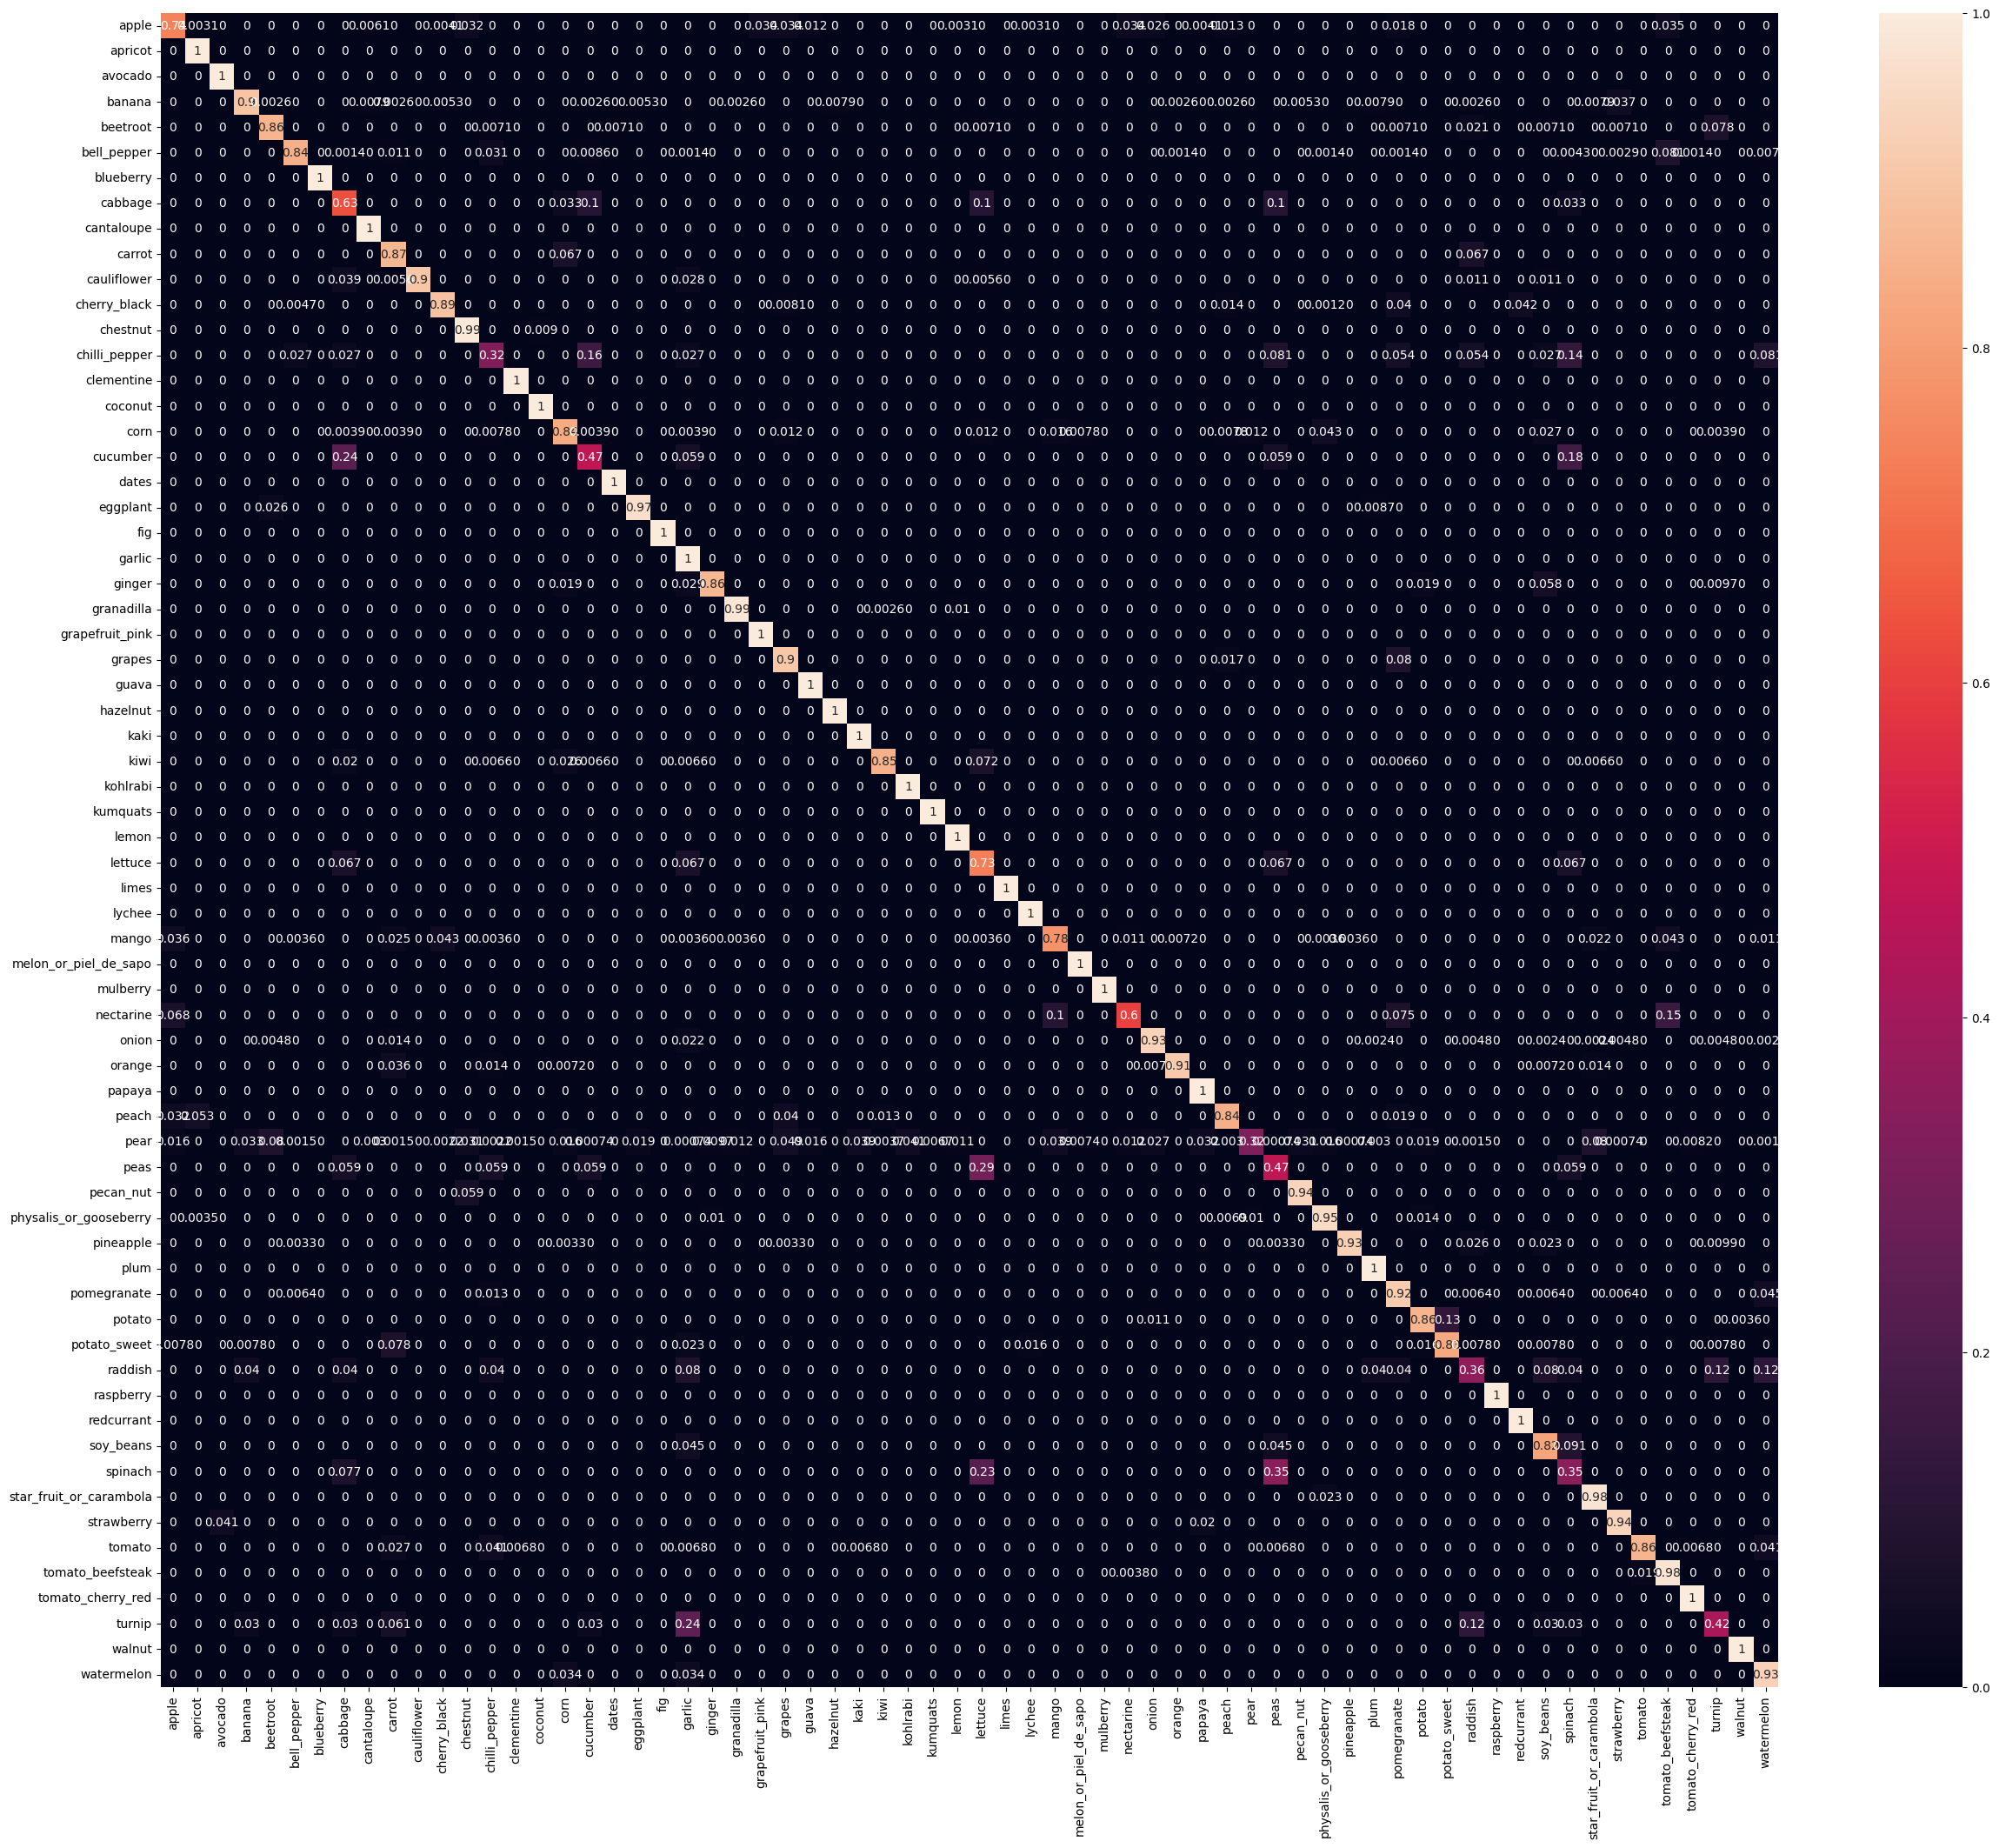

In [14]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
classes = dataset.class_to_idx.keys()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(30, 25))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'CV_data/conf_matrix/{model_name}-output.pdf')

# Test examples

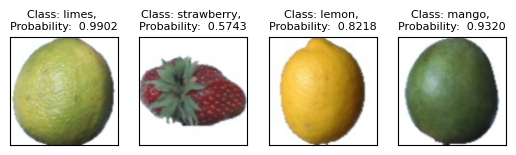

In [15]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


# Own photos

In [17]:
import os
path = "CV_data/own_photos/"
classes = os.listdir(path)
classes = [fldr for fldr in classes if not fldr.startswith('.')]

print(classes)

transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

custom_test_dataset = datasets.ImageFolder(root=path, transform=transform)

custom_test_loader = DataLoader(dataset=custom_test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


['banana', 'mango', 'apple']


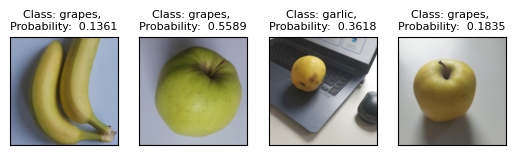

In [18]:
for batch_idx, (features, targets) in enumerate(custom_test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

In [19]:
from lib.nutrifacts import retrieve_nutrition_facts
import json

from IPython.core.display import HTML
HTML("&micro;")

print(json.dumps(retrieve_nutrition_facts(classes[2]["class"]), indent=4))

{'Food_Group': 'Vegetables', 'Food Name': 'Garlic raw', 'Energy(kcal)': 158, 'Water(g)': '58,6', 'Protein(g)': '6,4', 'Fat(g)': '0,5', 'Fatty_acids_total(g)': '0,3', 'Fatty acids saturated total(g)': '0,1', 'Carbohydrate(g)': '31', 'Sugar(g)': '1', 'Starch(g)': '30', 'Fiber dietary total(g)': '2,1', 'Na(mg)': 17.0, 'K(mg)': 401.0, 'Ca(mg)': 11.0, 'P(mg)': 153.0, 'Mg(mg)': 25.0, 'Fe(mg)': '1,7', 'Cu(mg)': '0,3', 'Se(µg)': 14.0, 'Zn(mg)': '1,16', 'Id(µg)': '3', 'Vitamin_D(µg)': '0', 'Vitamin_E(mg)': '0,1', 'Vitamin_K(µg)': '1,7', 'Vitamin_B1(mg)': '0,2', 'Vitamin_B2(mg)': '0,11', 'Vitamin_B6(mg)': '1,235', 'Vitamin_B12(µg)': '0', 'Vitamin_B3(mg)': '0,7', 'Vitamin_C(mg)': 0.0, 'Vitamin_A': 15.0}
{
    "Food Name": "Garlic raw",
    "Energy(kcal)": 158,
    "Water(g)": 58.6,
    "Protein(g)": 6.4,
    "Fat(g)": 0.5,
    "Fatty_acids_total(g)": 0.3,
    "Fatty acids saturated total(g)": 0.1,
    "Carbohydrate(g)": 31.0,
    "Sugar(g)": 1.0,
    "Starch(g)": 30.0,
    "Fiber dietary total(g)